In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# always import gbm_algos first !
import xgboost, lightgbm, catboost

# Core
import numpy as np
import scipy.io as io
from torch.autograd import grad
from torch.utils.data import DataLoader, Dataset

# Sklearn
from sklearn.ensemble import RandomForestRegressor
from mlens.ensemble import SuperLearner

# Let's do facy optimizers
from optimizers import Lookahead, AdamGC, SGDGC
from madgrad import MADGRAD
from lbfgsnew import LBFGSNew
# Modify at /usr/local/lib/python3.9/site-packages/torch_lr_finder/lr_finder.py
from torch_lr_finder import LRFinder
from onecyclelr import OneCycleLR
import pcgrad
from pytorch_stats_loss import torch_wasserstein_loss, torch_energy_loss
from geomloss import SamplesLoss
from utils import *

from tqdm import trange

from pde_diff import *
from robust_pde_diff import print_pde, RobustPCA, Robust_LRSTR

Populating the interactive namespace from numpy and matplotlib


[MLENS] backend: threading


[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Running Python 3.9.7
You can use npar for np.array


In [2]:
DATA_PATH = "./experimental_data/burgers_shock.mat"
data = io.loadmat(DATA_PATH)

t = data['t'].flatten()[:,None]; dt = t[1]-t[0]; nt = len(t)
x = data['x'].flatten()[:,None]; dx = x[1]-x[0]; nx = len(x)
u = np.real(data['usol'])
Exact = u.T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

<ipython-input-3-5ddf9840963f>:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig1.gca(projection='3d')


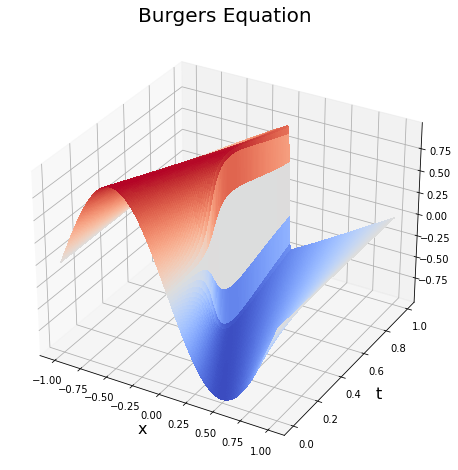

In [3]:
fig1 = figure()
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(X, T, u.T, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
title('Burgers Equation', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('t', fontsize = 16)
plt.show()

In [4]:
numpy.random.seed(0)
u = u + 0.01*std(u)*np.random.randn(u.shape[0],u.shape[1])

In [5]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]

['1',
 'u',
 'u^2',
 'u^3',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u^3u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'u^3u_{xx}',
 'u_{xxx}',
 'uu_{xxx}',
 'u^2u_{xxx}',
 'u^3u_{xxx}']

In [6]:
# Solve noiseless data with STRidge
w = TrainSTRidge(R, Ut, 10**-6, 10)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-0.072504 +0.000000i)uu_{x}
   


In [7]:
const = 0.01/np.pi
# err = 100*npar([1-0.998616, (0.004401-const)/const])
# err.mean(), err.std()

In [8]:
Z, E1 = RobustPCA(u, lam_2 = 0.3)
Ut, R, rhs_des = build_linear_system(Z, dt, dx, D=3, P=3, time_diff='FD', space_diff='FD')

# Solve noiseless data with RPCA + STR
w = TrainSTRidge(R, Ut, 10**-6, 10)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

# Solve noiseless data with RPCA+LRSTR
Ut1 = np.reshape(Ut, (nx, nt))
w, X, E2 = Robust_LRSTR(R, Ut1, rhs_des, lam_1 = 1e-5, lam_3 = 1.0, lam_4 = 1e-4, d_tol = 10)
print("PDE derived using RPCA+LRSTR for clear data U")
print_pde(w, rhs_des)

Please ensure that the shape of U is correct.
iteration:1, err:779.5610074981638, nc_norm:238.71429063566444 eta1:0.013990144383972824
iteration:50, err:0.027975438269530025, nc_norm:206.29011418053113 eta1:1.4930136192224146
iteration:78, err:6.151258405898329e-06, nc_norm:137.72802480920151 eta1:21.53073986341981
PDE derived using STRidge
u_t = (-0.072504 +0.000000i)uu_{x}
   
iteration:1, err:1138.465059195673, nc_norm:1876.2855890594042 eta2:0.009849105421015593
u_t = 
iteration:2, err:2.5809744034556694e-06, nc_norm:11195.58723405972 eta2:0.011818926505218711
u_t = 
IALM Finished at iteration 2
u_t = (-0.072504 +0.000000i)uu_{x}
   
PDE derived using RPCA+LRSTR for clear data U
u_t = (-0.072504 +0.000000i)uu_{x}
   


In [9]:
const = 0.01/np.pi
# err = 100*npar([1-0.998616, (0.004401-const)/const])
# err.mean(), err.std()

In [11]:
# Noiseless
# u_t = (-0.998616 +0.000000i)uu_{x}
#     + (0.004401 +0.000000i)u_{xx}
# (19.1999463422434, 19.061546342243396)

# + Noise at labels
# u_t = (-0.072504 +0.000000i)uu_{x}
# Failed